In [31]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import cache
import math

In [2]:
type Node = int

In [3]:
DATASET_PATH = "../datasets/dblp.txt"

In [4]:
df = pd.read_csv(DATASET_PATH, sep="\t", names=["source", "target"])

In [5]:
df.head()

,source,target
0,0,1
1,0,2
2,0,4519
3,0,23073
4,0,33043


In [7]:
tiny_network = [
    [0,1,1,1,1,1,1],
    [1,0,0,0,1,0,0],
    [1,0,0,0,1,0,0],
    [1,0,0,0,1,1,0],
    [1,1,1,1,0,0,0],
    [1,0,0,1,0,0,0],
    [1,0,0,0,0,0,0],
]
tiny_network = nx.from_numpy_array(np.array(tiny_network))

In [6]:
vis_graph = nx.from_pandas_edgelist(df.head(120))
graph = nx.from_pandas_edgelist(df.sample(df.shape[0] // 50))
full_graph = nx.from_pandas_edgelist(df)

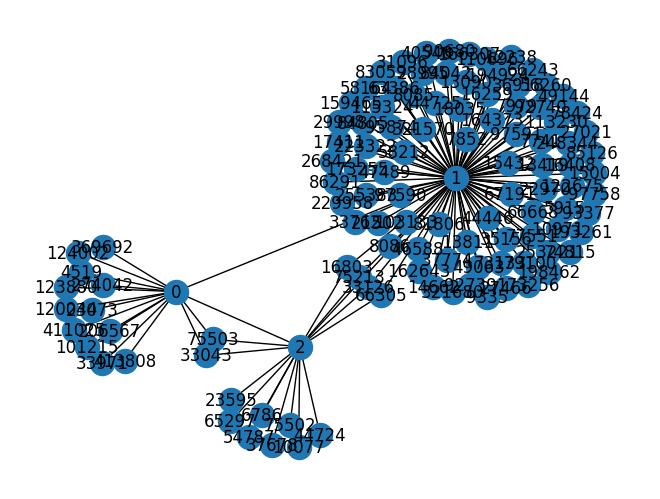

In [8]:
nx.draw(vis_graph, pos=nx.spring_layout(vis_graph, iterations=100, seed=1721), font_weight='light', with_labels=True)

In [ ]:
@cache
def all_kshell_values(graph: nx.Graph) -> dict[Node, int]:
    return nx.core_number(graph)

def kshell(graph: nx.Graph, node: Node) -> int:
    return all_kshell_values(graph)[node]

@cache
def all_iteration_kshell_values(graph: nx.Graph) -> dict[Node, int]:
    iks = {}
    remaining_nodes = set(graph.nodes)
    k = 1
    
    while remaining_nodes:
        shell = [node for node in remaining_nodes if graph.degree(node) <= k]
        
        while shell:
            for node in shell:
                iks[node] = k
                graph.remove_node(node)
            
            remaining_nodes -= set(shell)
            shell = [node for node in remaining_nodes if graph.degree(node) <= k]
        
        k += 1

    return iks

def iter_kshell(graph: nx.Graph, node: Node) -> int:
    return all_iteration_kshell_values(graph)[node]

def max_iter_kshell(graph: nx.Graph, node: Node) -> int:
    return max(all_iteration_kshell_values(graph).values())

def min_iter_kshell(graph: nx.Graph, node: Node) -> int:
    return min(all_iteration_kshell_values(graph).values())

def max_kshell(graph: nx.Graph):
    return max(all_kshell_values(graph).values())

def min_kshell(graph: nx.Graph):
    return min(all_kshell_values(graph).values())


In [10]:
def gravity_centrality(graph: nx.Graph, node: Node) -> float:
    influence_radius = 3
    acc = 0
    neighbors = set()
    path_lengths = {}

    for i in graph.nodes:
        if i != node:
            try:
                distance = nx.shortest_path_length(graph, i, node)
                path_lengths[(i, node)] = distance
                path_lengths[(node, i)] = distance
            except nx.NetworkXNoPath:
                pass


    for i in graph.nodes:
        path_length = path_lengths.get((i, node))
        if i != node and path_length and path_lengths[(i, node)] <= influence_radius:
            neighbors.add(i)

    for neighbor in neighbors:
        num = kshell(graph, node) * kshell(graph, neighbor)
        distance = path_lengths[(neighbor, node)]
        acc = num / distance

    return acc

In [19]:
def grav_coeff(graph: nx.Graph, i: Node, j: Node) -> float:
    g = np.power(np.e, (iter_kshell(graph, i) - iter_kshell(graph, j)) / (max_iter_kshell(graph) - min_iter_kshell(graph)))
    return g

In [ ]:
def gravitational_force(graph: nx.Graph, i: Node, j: Node) -> float:
    degree_prod = graph.degree[i] * graph.degree[j]
    distance = nx.shortest_path_length(graph, i, j)

    grav_coeff = grav_coeff(graph, i, j)

    return grav_coeff * degree_prod / np.square(distance)

In [20]:
def delta(graph: nx.Graph, i: Node, s: Node) -> float:
    power = (iter_kshell(graph, s) - iter_kshell(graph, i)) / (max_iter_kshell(graph) - min_iter_kshell(graph))
    return np.sqrt(np.pow(np.e, power))

In [13]:
def radius_of_influence(graph: nx.Graph, i: Node, s: Node, d: float | None) -> float | int:
    if d is None:
        d = delta(graph, i, s)

    distance = nx.shortest_path_length(graph, i, s)
    degree_quotient = nx.degree(graph, s) / nx.degree(graph, i)

    return distance / (1 + (np.sqrt(degree_quotient) * d))


In [26]:
def eigenvalue_decomposition(graph: nx.Graph) -> list[list[float]]:
    A = nx.to_numpy_array(graph)
    eigenvalues, eigenvectors = np.linalg.eig(A)

    D = np.diag(eigenvalues)

    Q = eigenvectors
    Q_inv = np.linalg.inv(Q)

    A = Q @ D @ Q_inv

    return A

In [32]:
def comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    diam = nx.diameter(graph)
    A = eigenvalue_decomposition(graph)
    X = A

    for i in range(1, diam + 1):
        X += (1/ math.factorial(i)) * A

    return X

In [ ]:
def cagm_algo_ranking(graph: nx.Graph):
    for i in graph.nodes():
        for delta in range(6, 17):
            delta = delta / 10

            s = i
            while s == i:
                s = np.random.choice(graph.nodes())

            radius = radius_of_influence(graph, i, s, delta)
            print(radius)

    # get inf_rad list based on tau ???

    for i in graph.nodes():
        for j in graph.nodes():
            # influence prob
            ...

    # normalize comm network matrix


In [22]:
cagm_algo_ranking(tiny_network)

0.6711869097939006
0.7121770656182413
0.6386979044864146
0.7313023567428015
0.6339745962155614
0.6115888892034832
0.5409709377719392
0.653286156469111
0.6363154356691957
0.5358983848622454
0.4335771643646627
1.25
1.1764705882352942
1.0102051443364382
1.2221979728810326
0.8989794855663562
0.3442037598196825
0.37077461428069897
0.3075346559802311
0.2919817890566451
0.7049408901788494
0.7692307692307692
1.25
1.1764705882352942
1.1111111111111112
0.439987429251267
1.0
0.39129219620451017
0.9090909090909091
0.3523015256659763
1.0050506338833465
0.8
0.6757688691736214
0.5907301480239406
1.2726308713383914
1.3681011474109308
0.5764197329674925
0.5505102572168219
0.39129219620451017
1.0102051443364382
0.3998223669359258
0.3821781531390199
0.4494897427831781
0.8671543287293254
0.6580613119579957
0.6225805807919257
1.4285714285714286
1.3793103448275863
1.3333333333333333
0.426036022737114
1.0819418755438783
1.042079799451461
0.5025253169416732
1.1428571428571428
0.3378844345868107
1.081941875543